# Set model to visualize
After setting these values, just run all cells. Double check data augmentation section.

In [34]:
# Model filename
# model-max/min/avg/middle-window-batch-learningrate-momentum-wd-epoch.params
model_fn = 'ResNet50_v2-middle-window2-batch16-lr0.001-mom0.9-wd0.0001-epoch39.params'

model_fn_bf = 'best.params'

### Set batch size and number of GPUs
 

In [8]:
per_device_batch_size = 1
num_gpus = 1
num_workers = 1
batch_size = per_device_batch_size * max(num_gpus, 1)

# Setup



### Install MXNet and GluonCV

In [3]:
!pip install --upgrade mxnet-cu101 gluoncv

     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:11tcmalloc: large alloc 1147494400 bytes == 0x653c4000 @  0x7feea8914615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 22kB/s 
     |████████████████████████████████| 819kB 46.6MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


### Import necessary packages

In [23]:
import mxnet as mx
import numpy as np
import os, time, shutil

from mxnet import gluon, image, init, nd, npx, ndarray
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.utils import makedirs, TrainingHistory
from gluoncv.model_zoo import get_model

import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from google.colab import files, drive 
import importlib
import pandas as pd
from PIL import Image

### Extract info from model filename

In [5]:
model_params = model_fn[:-7].split('-')
[model_name, agg_fn, window0] = model_params[:3]
window = window0[len('window'):]

# Data

### Mount Google Drive

In [24]:
!sed -i -e 's/enforce_single_parent:true/enforce_single_parent:true,metadata_cache_reset_counter:4/' /usr/local/lib/python3.6/dist-packages/google/colab/drive.py
_ = importlib.reload(drive)
drive.mount('/content/gdrive')
print(os.listdir('/content/gdrive/My Drive/'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['cs101', 'Getting started.pdf', 'Colab Notebooks', 'embryo_13_fluo_sequence.mp4', 'embryo_13_fluo_slice.mp4', 'embryo_13_bf_slice.mp4', 'embryo_13_bf_sequence.mp4', 'hi', 'embryo data.gsheet', 'classify_fluo_pretrained.ipynb', 'classify_fluo_CNN_2.ipynb', 'Copy of Pyramid Principle Exercise.gslides', 'dloss_100.npy', 'gloss_100.npy', 'generator_100.pth', 'discriminator_100.pth', 'ResNet50_v2-batch16-lr0.001-mom0.9-wd0.0001 (8)', 'ResNet50_v2-batch16-lr0.001-mom0 (2).9-wd0.0001-epoch0.params', 'ResNet50_v2-batch16-lr0.001-mom0 (2).9-wd0.0001-epoch1.params', 'ResNet50_v2-batch16-lr0.001-mom0 (1).9-wd0.0001-epoch2.params', 'ResNet50_v2-batch16-lr0.001-mom0 (1).9-wd0.0001-epoch3.params', 'ResNet50_v2-batch16-lr0.001-mom0 (1).9-wd0.0001-epoch4.params', 'ResNet50_v2-batch16-lr0.001-mom0 (1).9-wd0.0001-epoch5.params', 'ResNet50_v2-batch16-lr0.001-mom0 (1).9-wd0.0

### Define filepaths

In [25]:
home_path = '/content/gdrive/Shared drives/Embryo_data'

# Directories for input data
processed_path = f'{home_path}/processed'
train_path_bf = f'{processed_path}/pix2pix/train/bf_data'
val_path_bf = f'{processed_path}/pix2pix/val/bf_data'
test_path_bf = f'{processed_path}/pix2pix/test/bf_data'

### Data augmentation

In [26]:
transform_train = transforms.Compose([
    transforms.Resize(600, keep_ratio=True),
    transforms.CenterCrop(512),

    transforms.RandomFlipLeftRight(), # Randomly flip the image horizontally
    transforms.RandomFlipTopBottom(),
    transforms.RandomLighting(0.1), # Add AlexNet-style PCA-based noise to an image
    transforms.RandomContrast(0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(600, keep_ratio=True),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


### Define data loader

In [31]:
class ImageFolderDataset(gluon.data.Dataset):
    """A dataset for loading image files stored in a folder structure.

    like::

        root/car/0001.jpg
        root/car/xxxa.jpg
        root/car/yyyb.jpg
        root/bus/123.jpg
        root/bus/023.jpg
        root/bus/wwww.jpg

    Parameters
    ----------
    root : str
        Path to root directory.
    flag : {0, 1}, default 1
        If 0, always convert loaded images to greyscale (1 channel).
        If 1, always convert loaded images to colored (3 channels).
    transform : callable, default None
        A function that takes data and label and transforms them::

            transform = lambda data, label: (data.astype(np.float32)/255, label)

    Attributes
    ----------
    synsets : list
        List of class names. `synsets[i]` is the name for the integer label `i`
    items : list of tuples
        List of all images in (filename, label) pairs.
    """
    def __init__(self, root, flag=1, transform=None):
        self._root = os.path.expanduser(root)
        self._flag = flag
        self._transform = transform
        self._exts = ['.jpg', '.jpeg', '.png']
        self._list_images(self._root)

    def _list_images(self, root):
        self.items = []

        for filename in sorted(os.listdir(root)):
          filepath = os.path.join(root, filename)
          self.items.append(filepath)

    def __getitem__(self, idx):
        ind = self.items[idx].find('embryo')
        [embryo_num, embryo_t, label] = [int(num) for num in self.items[idx][ind:-4].split('_')[1:]]
        print(embryo_num, embryo_t, label)
        img = image.imread(self.items[idx], self._flag)
        if self._transform is not None:
            img = self._transform(img)
        return img, label, embryo_num, embryo_t

    def __len__(self):
        return len(self.items)

In [32]:
# Fluo
train_dataset = ImageFolderDataset(train_path).transform_first(transform_train)
val_dataset = ImageFolderDataset(val_path).transform_first(transform_train)
test_dataset = ImageFolderDataset(test_path).transform_first(transform_test)

train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_data = gluon.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers = num_workers)
test_data = gluon.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = num_workers)

# Bf
train_dataset_bf = ImageFolderDataset(train_path_bf).transform_first(transform_train)
val_dataset_bf = ImageFolderDataset(val_path_bf).transform_first(transform_train)
test_dataset_bf = ImageFolderDataset(test_path_bf).transform_first(transform_test)

train_data_bf = gluon.data.DataLoader(train_dataset_bf, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_data_bf = gluon.data.DataLoader(val_dataset_bf, batch_size=batch_size, shuffle=True, num_workers = num_workers)
test_data_bf = gluon.data.DataLoader(test_dataset_bf, batch_size=batch_size, shuffle=False, num_workers = num_workers)

# Model


In [36]:
classes = 2
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
print(ctx)

# Fluo
finetune_net = get_model(model_name, pretrained=True)
with finetune_net.name_scope():
    finetune_net.output = nn.Dense(classes)

finetune_net.output.initialize(init.Xavier(), ctx=ctx)
finetune_net.collect_params().reset_ctx(ctx)
finetune_net.hybridize()

model_fp = os.path.join(home_path, 'models', 'best', model_fn)
finetune_net.load_parameters(model_fp, ctx=ctx)

# Bf
finetune_net_bf = get_model(model_name, pretrained=True)
with finetune_net_bf.name_scope():
    finetune_net_bf.output = nn.Dense(classes)

finetune_net_bf.output.initialize(init.Xavier(), ctx=ctx)
finetune_net_bf.collect_params().reset_ctx(ctx)
finetune_net_bf.hybridize()

model_fp_bf = os.path.join('/content/gdrive/My Drive/cs101', 'models', 'best', model_fn_bf)
finetune_net_bf.load_parameters(model_fp_bf, ctx=ctx)

[gpu(0)]


### Calculate test accuracy

In [38]:
# define an evaluation function for validation and testing
def test(net, test_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(test_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

# run on test data (fluo)
_, test_acc = test(finetune_net, test_data, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

# run on test data (bf)
_, test_acc = test(finetune_net_bf, test_data_bf, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

[Finished] Test-acc: 0.871


# Visualize

### Summarize test prediction results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Text(0, 0.5, 'Label')

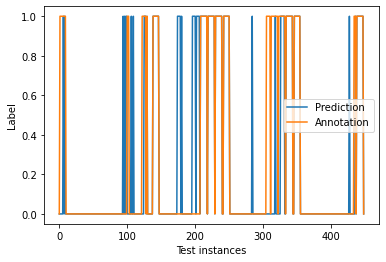

In [39]:
# summarize test prediction results (fluo)
record_pred = []
record_label = []
record_fn = []
for i, batch in enumerate(test_data):
  data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
  label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
  embryo_num = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0, even_split=False)
  embryo_t = gluon.utils.split_and_load(batch[3], ctx_list=ctx, batch_axis=0, even_split=False)
  fp = [os.path.join(test_path, str(label[j].asnumpy()[0]), f'embryo_{str(embryo_num[j].asnumpy()[0])}_{str(embryo_t[j].asnumpy()[0])}.png') for j in range(len(embryo_num))]
  outputs = [finetune_net(X) for X in data]
  a = np.argmax(outputs[0].asnumpy(),axis=1).astype('int32')
  b = label[0].asnumpy()
  if record_pred == []:
    record_pred = a
    record_label = b
    record_fn = fp
  else:
    record_pred = np.concatenate((record_pred, a), axis=0)
    record_label = np.concatenate((record_label, b), axis=0)
    record_fn = np.concatenate((record_fn, fp), axis=0)

plt.figure()
plt.plot(np.arange(len(record_pred)),record_pred,label='Prediction')
plt.plot(np.arange(len(record_label)),record_label,label='Annotation')
plt.legend()
plt.xlabel('Test instances')
plt.ylabel('Label')

# summarize test prediction results (bf)
record_pred_bf = []
record_label_bf = []
record_fn_bf = []
for i, batch in enumerate(test_data_bf):
  data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
  label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
  embryo_num = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0, even_split=False)
  embryo_t = gluon.utils.split_and_load(batch[3], ctx_list=ctx, batch_axis=0, even_split=False)
  fp = [os.path.join(test_path_bf, str(label[j].asnumpy()[0]), f'embryo_{str(embryo_num[j].asnumpy()[0])}_{str(embryo_t[j].asnumpy()[0])}.png') for j in range(len(embryo_num))]
  outputs = [finetune_net_bf(X) for X in data]
  a = np.argmax(outputs[0].asnumpy(),axis=1).astype('int32')
  b = label[0].asnumpy()
  if record_pred_bf == []:
    record_pred_bf = a
    record_label_bf = b
    record_fn_bf = fp
  else:
    record_pred_bf = np.concatenate((record_pred_bf, a), axis=0)
    record_label_bf = np.concatenate((record_label_bf, b), axis=0)
    record_fn_bf = np.concatenate((record_fn_bf, fp), axis=0)

plt.figure()
plt.plot(np.arange(len(record_pred_bf)),record_pred_bf,label='Prediction')
plt.plot(np.arange(len(record_label_bf)),record_label_bf,label='Annotation')
plt.legend()
plt.xlabel('Test instances')
plt.ylabel('Label')

### Confusion matrix

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['no polarization','polarization']
cm = confusion_matrix(record_label, record_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt="d", ax=ax) # annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['no polarization', 'polarization'])
ax.yaxis.set_ticklabels(['no polarization', 'polarization'], rotation='horizontal')
ax.set_aspect('equal', 'box')

NameError: ignored

### Attention of CNN

This section refers to https://discuss.mxnet.io/t/how-to-visualize-image-classification-resnetv2/4969

Another similar realization can be seen in https://github.com/nicklhy/CAM/blob/master/cam.ipynb

About Class Activation Maps(CAM):
https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-class-activation-maps-fe94eda4cef1

In [41]:
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable

def returnCAM(feature_conv, weight_softmax, idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    return cv2.resize(cam, size_upsample)

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def collapse_same_frame(images):
  delete_idx = []
  for i in range(images.shape[-1]):
    img1 = images[:,:,i]
    for j in range(i+1,images.shape[-1]):
      img2 = images[:,:,j]
      if np.array_equal(img1,img2):
        delete_idx.append(j) 
  images_return = np.delete(images,np.unique(np.asarray(delete_idx)),-1)
  return images_return 

# define a helper to display multiple images in a row in notebook
def show_images(images, titles, cmaps, vmin_lst, vmax_lst):
    num_images = len(images)
    rows, cols = 1, num_images

    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    for i in range(num_images):
        img = images[i]
        vmin = vmin_lst[i]
        vmax = vmax_lst[i]
        axs[i].set_title(titles[i])

        if len(img.shape)==2:
          im = axs[i].imshow(img, cmap=cmaps[i], vmin=vmin, vmax=vmax)
          # create an axes on the right side of ax. The width of cax will be 5%
          # of ax and the padding between cax and ax will be fixed at 0.05 inch.
          divider = make_axes_locatable(axs[i])
          cax = divider.append_axes("right", size="5%", pad=0.05)
          # norm = mpl.colors.Normalize(vmin=-5, vmax=10)
          # cb1 = mpl.colorbar.ColorbarBase(cax, cmap=mpl.cm.gist_rainbow,
          #                       norm=norm,
          #                       orientation='vertical')
          plt.colorbar(im, cax=cax)
        else:
          im = axs[i].imshow(img, cmap=cmaps[i])
    return fig

In [54]:
def find_heatmap_and_test_image(finetune_net, test_image, test_label, model_name):
  output = finetune_net(test_image)
  classes = ['no polarization','polarization']
  idx = mx.nd.argmax(output).asscalar().astype('int32')

  features_blob, weight_softmax = find_resnet_features(finetune_net, test_image, model_name)

  CAMs = returnCAM(features_blob, weight_softmax, idx)
  _ , _ , height, width = test_image.shape
  test_CAM = cv2.resize(CAMs,(width, height))
  print('Annotated label: %s'%classes[int(test_label)])
  print('Network prediction: %s'%classes[idx])

  # convert <NDArray 1x3x512x512 @gpu(0)> to <NumArray 512x512x3 @memory>
  test_image_narray = np.swapaxes(np.swapaxes(np.squeeze(test_image.asnumpy()),0,2), 0, 1)
  test_image_narray = (NormalizeData(test_image_narray)*255).astype(np.uint8)

  test_image_squeeze = np.squeeze(collapse_same_frame(test_image_narray))

  return test_CAM, test_image_squeeze, idx


def find_resnet_features(finetune_net, test_image, model_name):
  if model_name.lower() == 'resnet50_v2':
    params_list = list(finetune_net.collect_params())
    weight_softmax = finetune_net.collect_params()[params_list[-2]].data().asnumpy()
    features_blob = finetune_net.features[:-4](test_image).asnumpy()
  else:
    raise Exception('Model name {} not recognized'.format(model_name))
  return features_blob, weight_softmax


def visualize_CAM_and_fluo_data(test_CAM_lst, test_image_squeeze_lst, im_type_lst, fig_title_lst):
  assert(len(test_CAM_lst) == len(test_image_squeeze_lst))
  assert(len(test_CAM_lst) == len(im_type_lst))
  assert(len(test_CAM_lst) == len(fig_title_lst))

  # Find min and max of all images to visualize for color map
  vmin = min([np.min(test_CAM) for test_CAM in test_CAM_lst])
  vmax = max([np.max(test_CAM) for test_CAM in test_CAM_lst])

  for i in range(len(test_CAM_lst)):
    test_CAM = test_CAM_lst[i]
    test_image_squeeze = test_image_squeeze_lst[i]
    im_type = im_type_lst[i]
    fig_title = fig_title_lst[i]
    images = []
    images.append(test_CAM)
    images.append(cv2.equalizeHist(cv2.cvtColor(test_image_squeeze,cv2.COLOR_BGR2GRAY)))

    titles = [fig_title + ' CAM', 'CAM+' + im_type, im_type]
    cmaps = ['seismic', None]
    vmin_lst = [vmin, None]
    vmax_lst = [vmax, None]
    fig = show_images(images, titles, cmaps, vmin_lst, vmax_lst)

#### Specify test image

In [55]:
def find_class(file_path, embryo_num, embryo_t, classes_dirs):
  fn = None
  for cl in classes_dirs:
    fn_new = os.path.join(file_path, f'embryo_{embryo_num}_{embryo_t}_{cl}.png')
    if os.path.isfile(fn_new):
      return cl
  return

Annotated label: no polarization
Network prediction: no polarization


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


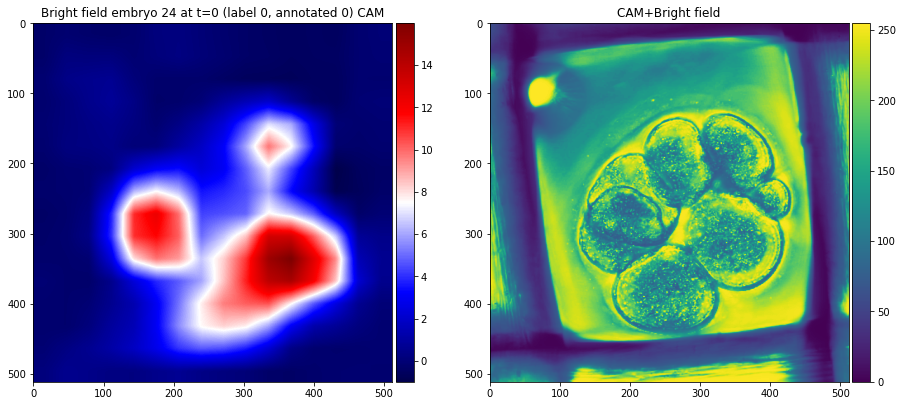

In [56]:
classes_dirs = ['0', '1']

embryo_num_lst = [24]
embryo_t_lst = [0]


test_CAM_lst, test_image_squeeze_lst, im_type_lst, fig_title_lst = [], [], [], []
for i in range(len(embryo_num_lst)):
  embryo_num = embryo_num_lst[i]
  embryo_t = embryo_t_lst[i]

  # Fluo
  im_type = 'Fluorescence'
  test_label = find_class(test_path, embryo_num, embryo_t, classes_dirs)
  test_image_fn = os.path.join(test_path, f'embryo_{embryo_num}_{embryo_t}_{test_label}.png')
  test_image = transform_test(image.imread(test_image_fn).copyto(ctx[0])).expand_dims(0)

  test_CAM, test_image_squeeze, test_annot = find_heatmap_and_test_image(finetune_net, test_image, test_label, model_name)
  fig_title = f'{im_type} embryo {embryo_num} at t={embryo_t}, label {test_label}, annotated {test_annot}'

  test_CAM_lst.append(test_CAM)
  test_image_squeeze_lst.append(test_image_squeeze)
  im_type_lst.append(im_type)
  fig_title_lst.append(fig_title)

  # Bright field
  im_type = 'Bright field'
  test_label_bf = find_class(test_path_bf, embryo_num, embryo_t, classes_dirs)
  test_image_fn_bf = os.path.join(test_path_bf, f'embryo_{embryo_num}_{embryo_t}_{test_label_bf}.png')
  test_image_bf = transform_test(image.imread(test_image_fn_bf).copyto(ctx[0])).expand_dims(0)

  test_CAM, test_image_squeeze, test_annot = find_heatmap_and_test_image(finetune_net_bf, test_image_bf, test_label_bf, model_name)
  fig_title = f'{im_type} embryo {embryo_num} at t={embryo_t} (label {test_label_bf}, annotated {test_annot})'

  test_CAM_lst.append(test_CAM)
  test_image_squeeze_lst.append(test_image_squeeze)
  im_type_lst.append(im_type)
  fig_title_lst.append(fig_title)


visualize_CAM_and_fluo_data(test_CAM_lst, test_image_squeeze_lst, im_type_lst, fig_title_lst)

#### Wrong prediction

In [ ]:
tp = record_pred==record_label
itemindex = np.where(tp==False)
print(itemindex)

(array([103, 105, 106, 107, 109, 111, 113, 118, 130]),)


In [ ]:
FN_idx = 1
group_id = np.floor(itemindex[0][FN_idx]/batch_size)
for i, batch in enumerate(test_data):
    data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break
test_idx = np.remainder(itemindex[0][FN_idx], batch_size)

Annotated label: no polarization
Network prediction: no polarization


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


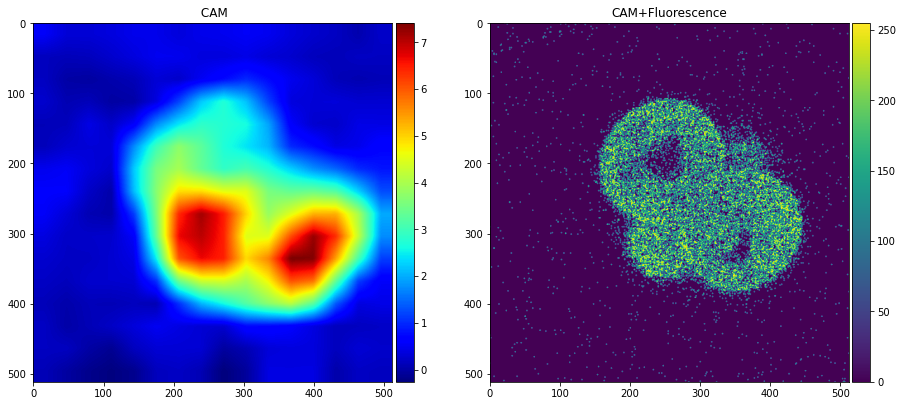

In [ ]:
test_CAM, test_image_squeeze, test_annot = find_heatmap_and_test_image(finetune_net, test_image, test_label, model_name)
visualize_CAM_and_fluo_data([test_CAM], [test_image_squeeze], ['Fluorescence'], [''])

In [ ]:
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        value = 128 + factor * (c - 128)
        return max(0, min(255, value))
    return img.point(contrast)


#### Mistakes

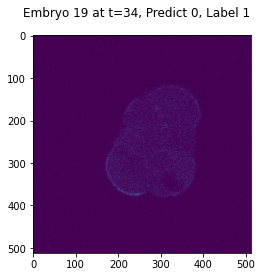

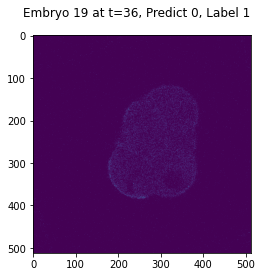

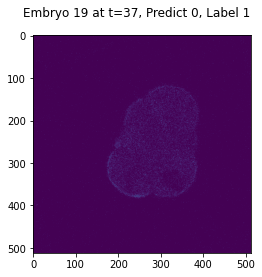

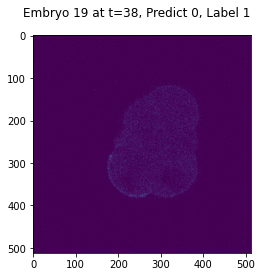

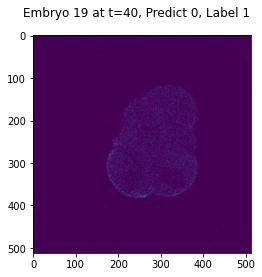

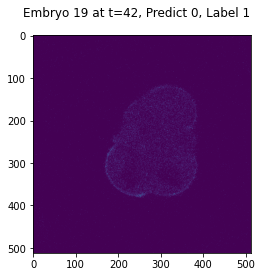

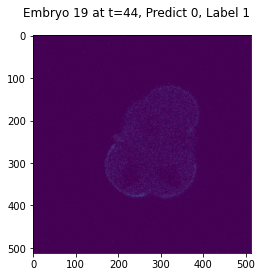

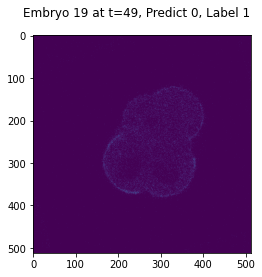

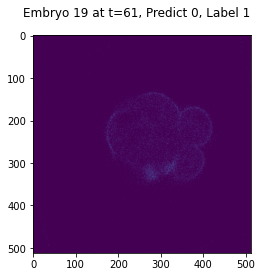

In [ ]:
for FN_idx in range(len(itemindex[0])):
  group_id = np.floor(itemindex[0][FN_idx]/batch_size)
  for i, batch in enumerate(test_data):
      data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
      label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
      if i == group_id:
        break
  test_idx = np.remainder(itemindex[0][FN_idx], batch_size)
  fn = record_fn[int(group_id)]
  im = Image.open(fn)
  fig = plt.figure()
  fn_lst = fn[:-4].split('_')
  embryo_num = int(fn_lst[-2])
  embryo_t = int(fn_lst[-1])
  fig.suptitle(f'Embryo {embryo_num} at t={embryo_t}, Predict {record_pred[int(group_id)]}, Label {record_label[int(group_id)]}')
  plt.imshow(im, vmin=0, vmax=255)